In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import tqdm
from scipy import signal
import glob

In [2]:
""" 
constants (not all needed but handy)
"""
pi = np.pi
c = sp.constants.c
epsilon_0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
kB = sp.constants.physical_constants['Boltzmann constant'][0]

#note: 
#turns out that h_bar is so small that Python does not deal well with it
#instead take hbar = 1

In [3]:
#time list for a single trajectory (experiment run)
ti = 0
tf = 5e-6
dt = 0.005e-6
t_list = np.arange(0, tf, dt)

# Frequency noise

In [6]:
shape(trace_list)

(32, 16384, 2)

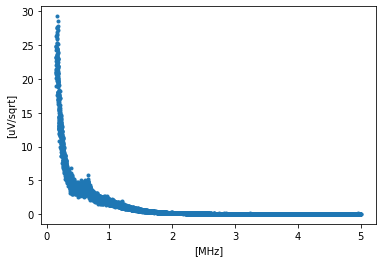

In [45]:
listfiles = glob.glob('604pdh/*.csv')
# listfiles = glob.glob('20221213-1MHzLowPass-bkg/*.csv')
# print(listfiles)
trace_list = []
g = 1
for filename in listfiles:
    trace_list.append(np.loadtxt(filename, delimiter=',', skiprows=3)) #770:800,1150:1180
trace0x, trace0y = np.mean(np.array(trace_list[:]), axis=0).transpose()[:,500:16384]
trace0x = trace0x*1e6
trace0y =( 0.775*np.power(10, trace0y/20)/g)/np.sqrt(trace0x[1]-trace0x[0])
plt.xlabel('[MHz]')
plt.ylabel('[uV/sqrt]')
plt.plot(trace0x/1e6, trace0y*1e6, '.')

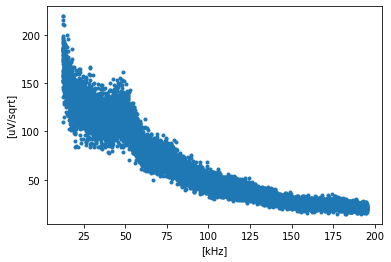

In [46]:
listfiles = glob.glob('604pdhzoom/*.csv')
# listfiles = glob.glob('20221213-1MHzLowPass-bkg/*.csv')
# print(listfiles)
trace_list = []
g = 1
for filename in listfiles:
    trace_list.append(np.loadtxt(filename, delimiter=',', skiprows=3)) #770:800,1150:1180
trace1x, trace1y = np.mean(np.array(trace_list[:]), axis=0).transpose()[:,1000:16000]
trace1x = trace1x*1e3
trace1y =( 0.775*np.power(10, trace1y/20)/g)/np.sqrt(trace1x[1]-trace1x[0])
plt.xlabel('[kHz]')
plt.ylabel('[uV/sqrt]')
plt.plot(trace1x/1e3, trace1y*1e6, '.')

In [47]:
trace = [np.concatenate((trace1x,trace0x), axis=0), np.concatenate(( trace1y,trace0y), axis=0)]

In [48]:
np.shape(trace)

(2, 30884)

Text(0, 0.5, 'V/sqrt(Hz)')

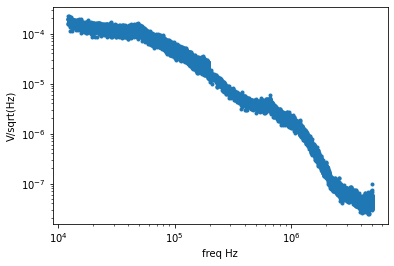

In [49]:
plt.loglog(trace[0], trace[1], '.')
np.savetxt('604_noise_PSD_VpersqrtHz.csv', [trace[0], trace[1]], delimiter=',',)
plt.xlabel('freq Hz')
plt.ylabel('V/sqrt(Hz)')
# plt.ylim(1e-7, 1e-4)

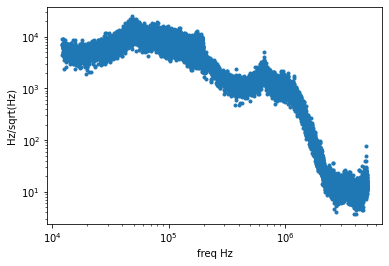

In [50]:
#conversion factor
linewidth = 40e3 #Hz
Kop = 200e-3/264e-6*35.3e-3/9.9e6

def K(f):
    return Kop/np.sqrt(1+4*f**2/linewidth**2)

PSDx = []
PSDy = []
for i, f in enumerate(trace[0]):
    PSDx.append(f)
    PSDy.append((trace[1][i]/K(trace[0][i]))**2)
plt.loglog(PSDx, PSDy, '.')
plt.xlabel('freq Hz')
plt.ylabel('Hz/sqrt(Hz)')
np.savetxt('604_noise_PSDHz2perHz.csv', [PSDx, PSDy], delimiter=',',)

In [51]:
#frequency list (x axis of your RIN)
fi_p = 4.3
#start
ff_p = 6.55 #stop
df_p = 0.02 #sampling bandwith 
f_list_p = np.power(10, np.arange(fi_p, ff_p, df_p))

In [52]:
PSDx, PSDymag = np.transpose(np.loadtxt('604_noise_PSDHz2perHz.csv', delimiter=',', unpack='True')) #phase noise psd
PSDymag = PSDymag*4*4 #doubling to 578
PSDx = PSDx #doubling to 578
PSD_fit = scipy.interpolate.make_interp_spline(PSDx, PSDymag, k=1)

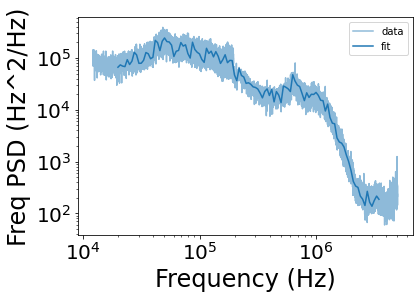

In [53]:
#plot phase noise realization
fig, axes = plt.subplots(1,1, figsize=(6,4))
axes.loglog(PSDx, PSDymag, color='tab:blue', alpha=0.5, label='data')
axes.loglog(f_list_p, PSD_fit(f_list_p)
            , color='tab:blue', alpha=1, label='fit')
axes.set_xlabel(r'Frequency (Hz)', fontsize=24)
axes.set_ylabel(r'Freq PSD (Hz^2/Hz)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best')
# plt.ylim(1e-8, 1e3)

In [54]:
#function to generate a phase noise trace

def phase_noise(t_list):
    
    phi_list = []
    
    population = np.linspace(0, 2*pi, 1000000)
    population=population.tolist()
    
    var_phi_list = random.sample(population, k=len(f_list_p)) #sample random phase from (0,2pi) one for each f

    for i, t in enumerate(t_list):
        phi = []

        for (idx, f) in enumerate(f_list_p[:-1]):
            S = PSD_fit(f) #frequency noise PSD
            df = f_list_p[idx+1] - f_list_p[idx]
            var_phi = var_phi_list[idx]
            phi.append(2*np.sqrt(S)*np.cos(2*pi *f*t + var_phi)*np.sqrt(df)/f)

        phi_list.append(np.sum(phi))
    return phi_list

In [55]:
phi_list = phase_noise(t_list) #example of a phase noise trace

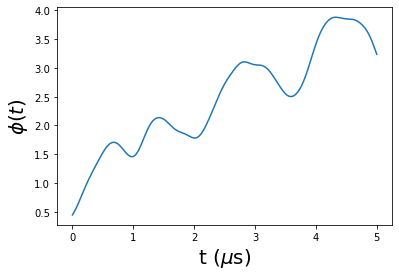

In [56]:
#plot phase noise realization
fig, axes = plt.subplots(1,1, figsize=(6,4))
axes.plot(t_list*1e6, phi_list)
axes.set_xlabel(r't ($\mu$s)', fontsize=20)
axes.set_ylabel(r'$\phi (t)$', fontsize=20); 

# Simulation

In [57]:
#define basis
g = basis(2,0)
e = basis(2,1)

#initial state
psi0 = g

#projection operators
proj_g = projection(2, 0, 0)
proj_e = projection(2, 1, 1)

In [58]:
#parameters
rabi = 2*pi*2e6 #Rabi freq in Hz
delta = 0 #laser detunning from excited state in Hz
lifetime = 37e-6 #excited state lifetime in s

gamma = 1. / lifetime # natural linewidth
decay = sigmap() #lowering operator (consistent with g,e basis)

# A list of jump operators
c_ops_inf = []
c_ops_fin = [np.sqrt(gamma)*decay] #finite lifetime effects included

In [59]:
#Hamiltonian
def H(rabi, delta, dP, phi):
    
    rabi_noisy = np.sqrt(1.+ dP)*rabi*np.exp(1j*phi)
    H0 = delta/2.*sigmaz()
    H1 = rabi_noisy/2.*sigmap() + np.conj(rabi_noisy)/2.*sigmam()
    
    return H0+H1

In [60]:
#effective Hamiltonian
def H_eff(H_coh, c_ops): 
    """Takes:
    - Hamiltonian describing the coherent dynamics, 
    - list of jump operators describing the decoherence of the system.
    Returns:
    - effective Hamiltonian
    """
    return H_coh - 1j/ 2. * sum([c.dag()*c for c in c_ops])

In [61]:
#probability of a particular jump
def jump_prob(psi, c, dt):
    return expect(c.dag()*c, psi)*dt

In [62]:
#tot jump probability
def tot_jump_prob(psi, c_ops, dt):
    return sum([jump_prob(psi, c, dt) for c in c_ops])

In [63]:
#Monte Carlo simulation
def MonteCarlo(t_list, dt, N_traj, rabi, delta, c_ops, psi0, A, B):
    """
    Takes:
    - time list for a single trajectory
    - evolution time step
    - number of trajectories to be computed, 
    - rabi frequecy
    - detunning
    - list of jump operators (c_ops=[] if not needed)
    - initial state
    - if A=0 omits phase noise
    - if B=0 omits intensity noise
    Returns: 
    - a list of N_traj lists containing excited population Pe(t) for t in t_list
    """
    
    traj_list = [] #empty list for lists of excited population

    for i in tqdm.trange(N_traj):
        
        if A:
            phi_run = phase_noise(t_list)
        else: 
            phi_run = np.zeros(len(t_list))
            
    
        if B:
            dP_run = intensity_noise(t_list)
        else: 
            dP_run = np.zeros(len(t_list))

        psi_list = [] #empty list for psi at times in t_list
  
        psi = psi0 #initialize wfn
        

        for idx,t in enumerate(t_list):
            psi_list.append(psi)
            
            phi = phi_run[idx]
            
            dP = dP_run[idx]
            if dP < -1:
                dP = -1

            #step 1: draw a random number from [0, 1]
            epsilon = random.random()

            #step 2: calculate probability of a jump
            dp = tot_jump_prob(psi, c_ops, dt)

            if dp < epsilon:
           
                H_coh = H(rabi, delta, dP, phi)
                
                #evolve wfn with effective Hamiltonian
                psi = psi - (1j*dt) * H_coh * psi
            
                #normalize the evolved wfn
                psi = psi / psi.norm() 

            else: #draw and apply a jump operator
                
                #index of the jump operator within c_ops list
                j = choice(np.arange(0, len(c_ops)), 1, p=[np.divide(jump_prob(psi, c, dt), dp) 
                                                           for c in c_ops]) 
                jump = c_ops[int(j)] #define the jump operator
                psi = jump*psi / np.sqrt(jump_prob(psi, jump, dt) / dt) #apply the jump operator
                #print('bah') #wfn collapse

        #density matrices for each time instance
        dm = [ket2dm(psi) for psi in psi_list]
        
        #excited state population
        Pe = [(proj_e*Q).tr() for Q in dm]

        traj_list.append(Pe)
        
    return traj_list

In [64]:
def decay_fit(t, tau, rabi):
    return 1/2*(1-np.exp(-t**2/tau**2)*np.cos(rabi*t))

In [65]:
result = MonteCarlo(t_list, dt, 100, rabi, delta, c_ops_inf, psi0, 1, 0)

100%|████████████████████████████████████████| 100/100 [03:51<00:00,  2.31s/it]


In [66]:
#avg excited state population as a function of time
avgPe_list = []
for i, t in enumerate(t_list):
    avgPe = 0
    for Pe in result:
        avgPe = avgPe + Pe[i]/len(result)
        
    avgPe_list.append(avgPe)

In [67]:
#infinite lifetime
guess=[50e-6, 2*pi*200e3]
popt, pcov = sp.optimize.curve_fit(decay_fit, t_list, avgPe_list, p0=guess)
tau = popt[0]
rabi_fit = popt[1]

print('1/e tau:', tau*1e6, 'us')
print('Number of Rabi cycles: ', rabi*tau/2/pi)
print('rabi:', rabi_fit/2/pi, 'x 2pi Hz')

1/e tau: 1331432.4173045282 us
Number of Rabi cycles:  2662864.8346090564
rabi: 175915.53829779386 x 2pi Hz


(0.9, 1.0)

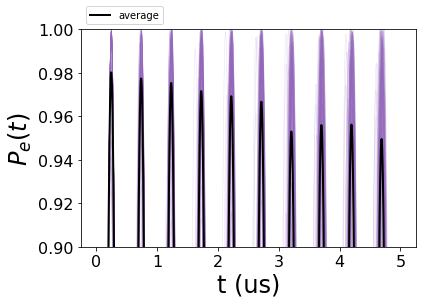

In [73]:
#plot Rabi oscillations
fig, axes = plt.subplots(1,1, figsize=(6,4))
for i, Pe in enumerate(result): #plot individual trajectories
    axes.plot(t_list*1e6, Pe, color='tab:purple', linestyle='-', marker='', alpha=0.2, linewidth=0.5)
axes.plot(t_list*1e6, avgPe_list, color='k', linestyle='-', marker='', alpha=1.0, linewidth=2, label='average')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(0,1), loc='lower left')
axes.set_xlabel(r't (us)', fontsize=24)
axes.set_ylabel(r'$P_e(t)$', fontsize=24);
plt.ylim(0.9, 1)

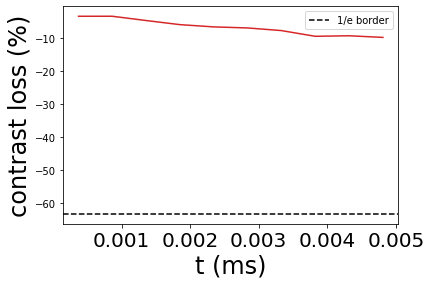

In [72]:
#contrast vs time plot
idx_min = np.asarray(sp.signal.argrelextrema(np.array(avgPe_list), np.less))[0]
idx_max = np.asarray(sp.signal.argrelextrema(np.array(avgPe_list), np.greater))[0]

Pe_max = [avgPe_list[p] for p in idx_max][:]
Pe_min = [avgPe_list[p] for p in idx_min]

t_max = [t_list[p] for p in idx_max][:]
t_min = [t_list[p] for p in idx_min]

t_avg = np.add(t_max, t_min) / 2.
contrast = np.subtract(Pe_max, Pe_min)/np.add(Pe_max, Pe_min)

#plot contrast
fig, axes = plt.subplots(1,1, figsize=(6,4))
axes.plot(t_avg*1e3, (contrast - 1)*100, color='tab:red', marker='', linestyle='-')
plt.axhline((1/np.e-1)*100, color='k', linestyle='--', label='1/e border')
axes.set_xlabel(r't (ms)', fontsize=24)
axes.set_ylabel(r'contrast loss (%)', fontsize=24)
plt.xticks(fontsize=20)
plt.legend(loc='best')

